# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [1]:
# !pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [2]:
import copy
import random
from collections import namedtuple, deque

import gymnasium as gym
import torch.optim as optim
from matplotlib import animation
from numpy import ndarray

from genepro.evo import Evolution
from genepro.multitree import Multitree
from genepro.node_impl import *
from genepro.node_impl import Constant

import csv
import os

import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised, used to later store animation frames of the environment.

#### Adding Wind

Wind can be added to the current environment setup as below:

```bash
env = gym.make("LunarLander-v3", continuous=False,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
```

Selin: When we add wind as a variable, it makes sense to also edit our fitness function. We can define a new boolean parameter (say have_random_wind) and if it is set to true when the fitness function is called, we can re-define the environment with a random wind value at each episode. This would potentially make our GP algorithm more robust to randomness. A possible implementation:

```bash
if use_random_wind:
    env = gym.make("LunarLander-v3", continuous=False,
                    enable_wind=True,
                    wind_power=np.random.uniform(5.0, 20.0),
                    turbulence_power=np.random.uniform(0.5, 2.0))
```

The above can be added within the loop that goes over the episodes (the outer for loop of the fitness function).

#### Adding new Atomic Functions

These atomic functions will be added as internal nodes within the Evolution setup.

We can add min & max operators. Or instead, we can add **Clamp(x, min, max)** operator. This could be interesting.

We can add domain specific operators:
- Maybe a function that calculates the angle of the lunarlander to the pad (angle_to_pad(x_pos, y_pos)?)

#### Fitness Calculation

For the final fitness calculation, we are taking the sum of the rewards across episodes. Instead of sum operation, can we do this fitness calculation in a more clever way?

In [3]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

In [4]:
perform_normal_evolution = False
perform_hyperparameter_testing = False
perform_fitness_test = False
perform_operator_test = False
perform_multiobjective_test = False
perform_diverse_init_test = True

In [5]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
        self.memory += other.memory
        return self

    def __add__(self, other):
        self.memory = self.memory + other.memory
        return self

In [6]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

### Selin's Notes

**Fitness Function:** Fitness is defined as the cumulative reward of the landing.

**Multitree:** Multitree contains 4 trees, one for each action of the Lunar lander. 

- `0`: do nothing
- `1`: fire left orientation engine
- `2`: fire main engine
- `3`: fire right orientation engine

Multitree is initialized under genepro/variation.py file, with the generate_random_multitree() method. This method is called in the genepro/evo.py file within the _initialize_population() internal method. 

**Understanding the Input Sample:** Input sample is an 8-dimensional vector: [x, y, vx, vy, angle, angular_velocity, leg1_contact, leg2_contact]

e.g. [-2.5, -2.5, -10, -10, -6.28, -10, 0, 0]

- index0 : x position of the lander
- index1: y position of the lander
- index2: velocity in the x direction
- index3: velocity in the y direction
- index4: angle of the lander
- index5: angular velocity
- index6: leg 1 in contact
- index7: leg 2 in contact
      


In [7]:
def make_fitness_function_pt(reduction="sum", has_wind=False):
    """
    Generic fitness function factory
    """

    def fitness_function(
        multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False
    ):
        memory = ReplayMemory(10000)
        episode_returns = []

        for _ in range(num_episodes):
            rewards = []
            # define a new environment with or without wind
            if has_wind:
                env = gym.make(
                    "LunarLander-v3",
                    render_mode="rgb_array",
                    enable_wind=True,
                    wind_power=np.random.uniform(
                        0.0, 2.0
                    ),  # TODO: Update the parameters for wind if necessary
                    turbulence_power=np.random.uniform(0.0, 1.0),
                )  # TODO: Update the parameters for turbulence if necessary
            else:
                env = gym.make("LunarLander-v3", render_mode="rgb_array")

            observation = env.reset()
            observation = observation[0]

            for _ in range(episode_duration):
                if render:
                    frames.append(env.render())

                input_sample = torch.from_numpy(
                    observation.reshape((1, -1))
                ).float()  # Input sample is a torch tensor

                # what goes here? TODO
                """Below is Selin's possible definition of an action"""
                output_scores = multitree.get_output_pt(
                    input_sample
                )  # A tensor of length 4, storing the scores of each action (after evaluating each tree)
                action = torch.argmax(
                    output_scores, dim=1
                )  # Select the action with the highest score
                observation, reward, terminated, truncated, info = env.step(
                    action.item()
                )
                rewards.append(reward)
                output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
                memory.push(
                    input_sample,
                    torch.tensor([[action.item()]]),
                    output_sample,
                    torch.tensor([reward]),
                )
                if (terminated or truncated) and not ignore_done:
                    break

            # Store the sum of rewards for this episode
            episode_returns.append(np.sum(rewards))

        # Define the reward types here
        # TODO: Add more reward types!
        if reduction == "sum":
            fitness = np.sum(episode_returns)
        elif reduction == "avg":
            fitness = np.sum(episode_returns) / num_episodes
        elif reduction == "min":
            fitness = np.min(episode_returns)
        else:
            raise ValueError(f"Unknown reduction method: {reduction}")

        return fitness, memory

    return fitness_function

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

#### Selin's ideas about the things they wanted us to consider in the evolution setup (possible areas for improvement)

In the below code, it says **Think about the probability of sampling a coefficient (which is basically a constant).** Currently, in the below code, we have 8 features and we are adding all of them as leaf nodes. 

However, we are only adding 1 constant as a leaf node. So this would give us a 1/9 chance of sampling a coefficient. This is a very small probability. Hence, **a possible area of improvement** might be to consider adding more constants (e.g. 4 or 5 constants) to our leaf nodes set and see how our GP performs. I think having constant is **important** because they allow the model to shift or scale features (e.g. x_4 + 1.5).

**Having more operators:** Currently, we only have basic arithmetic operators. We can add the following non-linear operators:
- log
- sqrt
- sin, cos
- max, min
- exp
- square, cube, ...

**Adjusting the parameters of the Evolution() method** called below. We can design an experiment to find the best combination of parameter values for population size, max generations, and max tree size.

In [8]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [
    Constant()
]  # Think about the probability of sampling a coefficient
internal_nodes = [Plus(), Minus(), Times(), Div()]  # Add your own operators here

fitness_function_pt = make_fitness_function_pt(
    reduction="sum"
)  # Baseline fitness function

evo = Evolution(
    fitness_function_pt,
    internal_nodes,
    leaf_nodes,
    4,
    pop_size=16,
    max_gens=10,
    max_tree_size=31,
    n_jobs=8,
    verbose=True,
)

## Evolve
Running this cell will use all the settings above as parameters

In [9]:
if perform_normal_evolution:
    best_fitnesses_across_gens = evo.evolve(is_multiobjective=False)
    print(best_fitnesses_across_gens)

# Test

In [10]:
def get_test_score(tree, has_wind=False):
    rewards = []

    for i in range(10):
        # define a new environment with or without wind
        if has_wind:
            env = gym.make(
                "LunarLander-v3",
                render_mode="rgb_array",
                enable_wind=True,
                wind_power=np.random.uniform(
                    0.0, 2.0
                ),  # TODO: Update the parameters for wind if necessary
                turbulence_power=np.random.uniform(0.0, 1.0),
            )  # TODO: Update the parameters for turbulence if necessary
        else:
            env = gym.make("LunarLander-v3", render_mode="rgb_array")

        observation = env.reset(seed=i)
        observation = observation[0]

        for _ in range(500):
            # build up the input sample for GP
            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()

            # TODO: Again, define the action
            """Selin's idea of an action is added below"""
            # get output (squeezing because it is encapsulated in an array)
            output = tree.get_output_pt(input_sample)
            action = torch.argmax(
                output, dim=1
            )  # Select the action with the highest score

            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards.append(reward)
            output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            if terminated or truncated:
                break

    fitness = np.sum(rewards)

    return fitness


if perform_normal_evolution:
    best = evo.best_of_gens[-1]

    print(best.get_readable_repr())
    print(get_test_score(best))

## Our Experimentation Setup

In [11]:
def write_results_to_csv(
    internal_nodes,
    leaf_nodes,
    pop_size,
    max_gens,
    max_tree_size,
    crossover_rate,
    mutation_rate,
    coeff_opt_rate,
    tournament_size,
    best_training,
    best_test,
    average_fitness,
    time_elapsed,
    num_evals,
    filename="experiment_results_cr=0.500.csv",
):
    # Flatten node types to strings for logging
    internal_str = ",".join(type(node).__name__ for node in internal_nodes)
    leaf_str = ",".join(type(node).__name__ for node in leaf_nodes)

    # Build a dictionary of all results/settings
    row = {
        "internal_nodes": internal_str,
        "leaf_nodes": leaf_str,
        "pop_size": pop_size,
        "max_gens": max_gens,
        "max_tree_size": max_tree_size,
        "crossover_rate": crossover_rate,
        "mutation_rate": mutation_rate,
        "coeff_opt_rate": coeff_opt_rate,
        "tournament_size": tournament_size,
        "best_training": best_training,
        "best_test": best_test,
        "average_fitness": average_fitness,
        "time_elapsed": time_elapsed,
        "num_evals": num_evals,
    }

    file_exists = os.path.isfile(filename)
    with open(filename, mode="a", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list(row.keys()))
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)

## Main Experimentation Loop

In [12]:
from genepro.evo import (
    subtree_crossover,
    subtree_mutation,
    coeff_mutation,
    tournament_selection,
)

# Hyperparameters in the baseline implementation which will be kept as is
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [
    Constant()
]  # Think about the probability of sampling a coefficient
internal_nodes = [Plus(), Minus(), Times(), Div()]  # Add your own operators here


def main_experimentation_loop(
    fitness_function_version,
    internal_nodes,
    leaf_nodes,
    pop_size=64,
    max_gens=30,
    max_tree_size=31,
    crossover_rate=0.875,
    mutation_rate=0.025,
    coeff_opt_rate=0.1,
    tournament_size=8,
    is_multiobjective=False,
    is_diverse = False
):
    # Define the best-performing hyperparameters
    crossovers = [{"fun": subtree_crossover, "rate": crossover_rate}]
    mutations = [{"fun": subtree_mutation, "rate": mutation_rate}]
    coeff_opts = [{"fun": coeff_mutation, "rate": coeff_opt_rate}]
    selection = {
        "fun": tournament_selection,
        "kwargs": {"tournament_size": tournament_size},
    }

    # Initialize an evolution setup with the correct fitness function
    evo = Evolution(
        fitness_function_version,
        internal_nodes,
        leaf_nodes,
        n_trees=4,  # Number of trees in multitree is fixed to 4
        # resource settings
        pop_size=pop_size,
        max_gens=max_gens,
        max_tree_size=max_tree_size,
        # hyperparameter settings
        crossovers=crossovers,
        mutations=mutations,
        coeff_opts=coeff_opts,
        selection=selection,
        n_jobs=8,  # Number of jobs is fixed to 8 (used for parallel computing)
        verbose=True,
    )

    # Run the training loop for this evolution setup and get the fitnesses of the best individuals across generations
    best_fitnesses_training, average_fitness, time_elapsed, num_evals = evo.evolve(
        is_multiobjective=is_multiobjective, is_diverse_population=is_diverse
    )

    # Now, run the testing loop for this evolution setup and get the fitnesses of the best individuals across generations
    # Extract best-of-generation trees
    best_individuals = evo.best_of_gens

    # Collect test scores for each best individual across generations
    best_fitnesses_test = [get_test_score(ind) for ind in best_individuals]

    # Collect the average test score across the final population
    final_population = evo.population
    final_population_test_scores = [get_test_score(ind) for ind in final_population]
    average_fitness_test = np.mean(final_population_test_scores)

    return (
        best_fitnesses_training,
        best_fitnesses_test,
        average_fitness,
        average_fitness_test,
        time_elapsed,
        num_evals,
    )

## Optimizing the Baseline Model: Hyperparameter Testing

In [13]:
# BASELINE TEST. Hyperparameter Testing

from itertools import product

def hyperparameter_testing():
    crossover_rates = [0.5, 0.625, 0.75, 0.875, 1.0]
    mutation_rates = [0.01, 0.025, 0.05, 0.075, 0.125]
    coeff_opt_rates = [0.01, 0.025, 0.05, 0.075, 0.125, 0.25]
    tournament_sizes = [2, 4, 8, 16]

    total_runs = (
        len(crossover_rates)
        * len(mutation_rates)
        * len(coeff_opt_rates)
        * len(tournament_sizes)
    )
    run_idx = 1

    baseline_fitness_function = make_fitness_function_pt(
        reduction="sum"
    )  # Test against the baseline fitness function: sum of rewards

    for cr, mr, cor, ts in product(
        crossover_rates, mutation_rates, coeff_opt_rates, tournament_sizes
    ):
        print(
            f"\n=== Run {run_idx}/{total_runs} | CR={cr} MR={mr} CoeffR={cor} TS={ts} ==="
        )
        run_idx += 1

        try:
            (
                best_training,
                best_test,
                average_fitness,
                average_fitness_test,
                time_elapsed,
                num_evals,
            ) = main_experimentation_loop(
                fitness_function_version=baseline_fitness_function,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                crossover_rate=cr,
                mutation_rate=mr,
                coeff_opt_rate=cor,
                tournament_size=ts,
            )

            write_results_to_csv(
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                pop_size=64,
                max_gens=30,
                max_tree_size=31,
                crossover_rate=cr,
                mutation_rate=mr,
                coeff_opt_rate=cor,
                tournament_size=ts,
                best_training=best_training,
                best_test=best_test,
                average_fitness=average_fitness,
                time_elapsed=time_elapsed,
                num_evals=num_evals,
            )

        except Exception as e:
            print(
                f"Error in configuration CR={cr}, MR={mr}, CoeffR={cor}, TS={ts}: {e}"
            )
            continue


if perform_hyperparameter_testing:
    hyperparameter_testing()

## Test 1. Improving the Fitness Function

Configuring the fitness function:
- TEST 1.1 Single objective: Experiment with different quality metrics for fitness
- TEST 1.2 Multi-objective: Include diversity as a second metric

Required additional arguments for fitness function: has_wind=False, reward_type='sum', is_multiobjective=False where reward_types = ['sum', 'min', 'weighted_sum']

Wind Test: Adding wind as a variable, and also adding a random wind value at each episode

In [14]:
# TEST TYPE 1. Improving the Fitness Function
"""
Configuring the fitness function
TEST 1.1 Single objective: Experiment with different quality metrics for fitness
TEST 1.2 Multi-objective: Include diversity as a second metric

Required additional arguments for fitness function: has_wind=False, reward_type='sum', is_multiobjective=False
where reward_types = ['sum', 'min', 'weighted_sum']

Wind Test
Adding wind as a variable, and also adding a random wind value at each episode
"""

def write_results_to_csv_fitness_improvement(
    internal_nodes,
    leaf_nodes,
    has_wind,
    reward_type,
    pop_size,
    max_gens,
    best_training,
    best_test,
    average_fitness,
    time_elapsed,
    num_evals,
):
    # Flatten node types to strings for logging
    internal_str = ",".join(type(node).__name__ for node in internal_nodes)
    leaf_str = ",".join(type(node).__name__ for node in leaf_nodes)

    # Build a dictionary of all results/settings
    row = {
        "internal_nodes": internal_str,
        "leaf_nodes": leaf_str,
        "has_wind": has_wind,
        "reward_type": reward_type,
        "pop_size": pop_size,
        "max_gens": max_gens,
        "best_training": best_training,
        "best_test": best_test,
        "average_fitness": average_fitness,
        "time_elapsed": time_elapsed,
        "num_evals": num_evals,
    }

    name = "fitness_comp_improvement.csv"
    if has_wind:
        name = "fitness_comp_improvement_with_wind.csv"

    os.makedirs("improvement_results", exist_ok=True)
    filename = os.path.join("improvement_results", name)

    file_exists = os.path.isfile(filename)
    with open(filename, mode="a", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list(row.keys()))
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)


def fitness_function_reward_types_exp(max_gens=30, has_wind=False):
    reward_types = ["avg", "min"]  # Use average instead of sum for comparison purposes

    for _ in range(
        3
    ):  # Run the experiment for 3 times for each reward type (to account for randomness)
        for reward_type in reward_types:
            fitness_function_version = make_fitness_function_pt(
                reduction=reward_type, has_wind=has_wind
            )
            print(f"\nRunning experiment for reward type: {reward_type}")
            (
                best_training,
                best_test,
                average_fitness,
                average_fitness_test,
                time_elapsed,
                num_evals,
            ) = main_experimentation_loop(
                fitness_function_version,
                internal_nodes,
                leaf_nodes,
                pop_size=64,
                max_gens=max_gens,
                max_tree_size=31,
            )
            print(
                f"Best training fitness: {best_training}, Best test fitness: {best_test}, Average fitness: {average_fitness}, Average test fitness: {average_fitness_test}, Time elapsed: {time_elapsed}, Number of evaluations: {num_evals}"
            )
            write_results_to_csv_fitness_improvement(
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                has_wind=has_wind,
                reward_type=reward_type,
                pop_size=64,
                max_gens=max_gens,
                best_training=best_training,
                best_test=best_test,
                average_fitness=average_fitness,
                time_elapsed=time_elapsed,
                num_evals=num_evals,
            )

In [15]:
if perform_fitness_test:
    fitness_function_reward_types_exp(max_gens=50, has_wind=True)

In [16]:
def load_and_average_per_generation(csv_path, plot_type="Best"):
    """
    Method for averaging fitness values per generation across different experiment runs
    """
    df = pd.read_csv(csv_path)

    column_name = "best_training"
    if plot_type == "Average":
        column_name = "average_fitness"

    df[column_name] = df[column_name].apply(lambda s: eval(s, {"np": np}))
    df["best_test"] = df["best_test"].apply(lambda s: eval(s, {"np": np}))

    training_dict = defaultdict(list)
    test_dict = defaultdict(list)

    for _, row in df.iterrows():
        training_dict[row["reward_type"]].append(row[column_name])
        test_dict[row["reward_type"]].append(row["best_test"])

    # Average across runs for each generation
    averaged_training = []
    averaged_test = []
    reward_types = []

    for reward_type in sorted(training_dict.keys()):
        reward_types.append(reward_type)

        train_runs = np.array(training_dict[reward_type])
        test_runs = np.array(test_dict[reward_type])

        avg_train = np.mean(train_runs, axis=0).tolist()
        avg_test = np.mean(test_runs, axis=0).tolist()

        averaged_training.append(avg_train)
        averaged_test.append(avg_test)

    return averaged_training, averaged_test, reward_types


def plot_fitnesses_reward_types_exp(
    training_fitnesses, test_fitnesses, reward_types, plot_type="Best", has_wind=False
):
    print("Training fitnesses:", training_fitnesses)
    print("Test fitnesses:", test_fitnesses)
    generations = list(range(len(training_fitnesses[0])))

    plt.figure(figsize=(12, 5))

    # Training fitness plot
    plt.subplot(1, 2, 1)
    for i, reward_type in enumerate(reward_types):
        plt.plot(generations, training_fitnesses[i], label=reward_type)
    title_train = f"{plot_type} Training Fitness over Generations {'with Wind' if has_wind else 'without Wind'}"
    plt.title(title_train)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.legend()

    if plot_type == "Best":
        # Testing fitness plot
        plt.subplot(1, 2, 2)
        for i, reward_type in enumerate(reward_types):
            plt.plot(generations, test_fitnesses[i], label=reward_type)
        title_test = f"{plot_type} Testing Fitness over Generations {'with Wind' if has_wind else 'without Wind'}"
        plt.title(title_test)
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
if perform_fitness_test:
    csv_path = (
        "improvement_results/fitness_comp_improvement_with_wind.csv"  # or without wind
    )
    training_avg, test_avg, reward_types = load_and_average_per_generation(
        csv_path, plot_type="Best"
    )
    plot_fitnesses_reward_types_exp(
        training_avg, test_avg, reward_types, plot_type="Best", has_wind=True
    )

## Test 2: Operator Testing

In this test, we will experiment with adding more operators as opposed to the basic arithmetic operators. The test setup will follow the following steps:

1. First, test the best fitness (at the last generation) of the baseline implementation with the basic arithmetic operators.
2. We will also test the fitness when we add more operators to the internal nodes set, specifically all the non-linear operators defined in the genepro/node_impl.py file. We expect the fitness to decrease, as the search space will be larger. This initial test is to see if this hypothesis holds.
3. We will then give the algorithm more resources (twice the population size and twice the number of generations) and count which operators are present in the final trees. This will give us an idea of which operators are more useful in the context of the Lunar Lander environment.
4. The top half of the operators will be selected and used in the next test. The bottom half will be discarded. Now, these operators will be tested against the basic operators, expecting the fitness to be higher than the basic operators.

In [18]:
def operator_experimentation_loop(
    internal_nodes,
    pop_size=64,
    max_gens=50,
    max_tree_size=31,
    crossover_rate=0.875,
    mutation_rate=0.025,
    coeff_opt_rate=0.1,
    tournament_size=8,
    has_wind=False,
) -> tuple[ndarray[float], ndarray[float], list[Multitree]]:
    # Define the best-performing hyperparameters
    crossovers = [{"fun": subtree_crossover, "rate": crossover_rate}]
    mutations = [{"fun": subtree_mutation, "rate": mutation_rate}]
    coeff_opts = [{"fun": coeff_mutation, "rate": coeff_opt_rate}]
    selection = {
        "fun": tournament_selection,
        "kwargs": {"tournament_size": tournament_size},
    }

    leaf_nodes = [Feature(i) for i in range(num_features)]
    leaf_nodes = leaf_nodes + [Constant()]

    # Initialize an evolution setup with the correct fitness function
    evo = Evolution(
        make_fitness_function_pt(reduction="sum", has_wind=has_wind),
        internal_nodes,
        leaf_nodes,
        n_trees=4,  # Number of trees in multitree is fixed to 4
        # resource settings
        pop_size=pop_size,
        max_gens=max_gens,
        max_tree_size=max_tree_size,
        # hyperparameter settings
        crossovers=crossovers,
        mutations=mutations,
        coeff_opts=coeff_opts,
        selection=selection,
        n_jobs=8,  # Number of jobs is fixed to 8 (used for parallel computing)
        verbose=True,
    )

    # Run the training loop for this evolution setup and get the fitnesses of the best individuals across generations
    best_fitnesses_training, _, _, _ = evo.evolve()

    best_fitnesses_test = np.array([get_test_score(tree) for tree in evo.best_of_gens])

    return best_fitnesses_training, best_fitnesses_test, evo.population

In [19]:
from collections import defaultdict

CLASSNAME_TO_CLASS = {
    "Plus": Plus,
    "Minus": Minus,
    "Times": Times,
    "Div": Div,
    "Log": Log,
    "Sqrt": Sqrt,
    "Sin": Sin,
    "Cos": Cos,
    "Exp": Exp,
    "Square": Square,
    "Cube": Cube,
    "Max": Max,
    "Min": Min,
    "Sign": Sign,
    "Abs": Abs,
    "Clamp": Clamp,
}

OUTPUT_DIR = "operator_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create directory if it doesn't exist


class OperatorResults:
    def __init__(
        self,
        best_training: ndarray[float],
        best_test: ndarray[float],
        operator_count: defaultdict[str, int],
        name: str,
    ) -> None:
        self.best_training = best_training
        self.best_test = best_test
        self.operator_count = operator_count
        self.name = name


def count_operators(trees: list[Multitree]) -> defaultdict[str, int]:
    d = defaultdict(int)
    for tree in trees:
        for node in tree.children:
            if not (isinstance(node, Feature) or isinstance(node, Constant)):
                d[type(node).__name__] += 1
    return d


def save_results_to_json(
    results: OperatorResults, filename: str = "operator_results.json"
):
    import json

    file_path = os.path.join(OUTPUT_DIR, filename)

    data = {
        "best_training": results.best_training[-1],
        "best_test": results.best_test[-1],
        "operator_count": dict(results.operator_count),
    }

    with open(file_path, "w") as f:
        json.dump(data, f, indent=2)


def plot_operator_fitness(
    results: list[OperatorResults],
    filename: str = "operator_fitness_plot.png",
    has_wind: bool = False,
):
    file_path = os.path.join(OUTPUT_DIR, filename)

    plt.figure(figsize=(12, 5))

    for i, condition in enumerate(["Training", "Testing"]):
        plt.subplot(1, 2, i + 1)

        for result in results:
            if i == 1:
                plt.plot(result.best_test, label=result.name)
            else:
                plt.plot(result.best_training, label=result.name)

        plt.title(
            f"Operator Experiment: Best {condition} Fitness over Generations "
            f"{'with' if has_wind else 'without'} Wind"
        )
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend()
        plt.grid()
    plt.savefig(file_path)
    plt.show()

In [20]:
def operator_experiment(
    operators,
    filename,
    experiment_name,
    population_size=64,
    max_generations=50,
    has_wind=False,
):
    # Repeat experiment N times for robustness
    N = 3

    acc_best_training = np.zeros((N, max_generations + 1))
    acc_best_test = np.zeros((N, max_generations + 1))
    acc_population = []

    for i in range(N):
        print(f"Running {experiment_name.lower()} experiment {i + 1}/{N}")
        best_training, best_test, final_population = operator_experimentation_loop(
            operators,
            max_gens=max_generations,
            pop_size=population_size,
            has_wind=has_wind,
        )
        acc_best_training[i] = best_training
        acc_best_test[i] = best_test
        acc_population += final_population

    operators_used = count_operators(acc_population)

    results = OperatorResults(
        np.mean(acc_best_training, axis=0),
        np.mean(acc_best_test, axis=0),
        operators_used,
        experiment_name,
    )

    save_results_to_json(results, filename)

    return results

In [21]:
if perform_operator_test:
    # Without wind
    basic_operators = [Plus(), Minus(), Times(), Div()]
    basic_results = operator_experiment(
        basic_operators, "basic.json", "Basic Operators"
    )

    all_operators = basic_operators + [
        Log(),
        Sqrt(),
        Sin(),
        Cos(),
        Exp(),
        Square(),
        Cube(),
        Max(),
        Min(),
        Sign(),
        Abs(),
        Clamp(),
    ]
    all_ops_results = operator_experiment(
        all_operators,
        "all_operators_small_resources.json",
        "All Operators",
    )

    all_ops_large_results = operator_experiment(
        all_operators,
        "all_operators_more_resources.json",
        "All Operators (More Resources)",
        population_size=256,
        max_generations=100,
    )

    top8 = sorted(
        all_ops_large_results.operator_count.items(),
        key=lambda x: x[1],
        reverse=True,
    )[:8]
    top8_operators = [CLASSNAME_TO_CLASS[name]() for name, _ in top8]

    top8_results = operator_experiment(
        top8_operators, "top8_operators.json", "Top 8 Operators"
    )

    # Plot the results (without wind)
    all_results = [basic_results, all_ops_results, top8_results]
    plot_operator_fitness(all_results, "best_operator_fitness.png")

    # With wind
    print("Running experiments with wind...")
    basic_results_wind = operator_experiment(
        basic_operators, "basic_wind.json", "Basic", has_wind=True
    )
    all_ops_results_wind = operator_experiment(
        all_operators,
        "all_operators_small_resources_wind.json",
        "All Operators",
        has_wind=True,
    )
    top8_results_wind = operator_experiment(
        top8_operators, "top8_wind.json", "Top 8 Operators", has_wind=True
    )

    # Plot the results (with wind)
    plot_operator_fitness(
        [basic_results_wind, all_ops_results_wind, top8_results_wind],
        "best_operator_fitness_wind.png",
        has_wind=True,
    )

## Test 3. Multi-objective Optimization

We will take diversity into account in addition to fitness. Hence, we will select the best parents by creating a Pareto front and optimizing against maximizing diversity and fitness. For this purpose, we will use the fast non-dominated sorting algorithm and maximum Pareto domination. 

Reformulating the problem as a multi-objective problem is important to overcome the problem of having very similar individuals in the population after a few rounds of the algorithm, possibly forcing the algorithm to converge on a sub-optimal solution.


In [22]:
def write_results_to_csv_multiobjective(
    internal_nodes,
    leaf_nodes,
    has_wind,
    reward_type,
    is_multiobjective,
    pop_size,
    max_gens,
    best_training,
    best_test,
    average_fitness,
    time_elapsed,
    num_evals,
    test_name = "multiobjective_improvement.csv"
):

    # Flatten node types to strings for logging
    internal_str = ",".join(type(node).__name__ for node in internal_nodes)
    leaf_str = ",".join(type(node).__name__ for node in leaf_nodes)

    # Build a dictionary of all results/settings
    row = {
        "internal_nodes": internal_str,
        "leaf_nodes": leaf_str,
        "has_wind": has_wind,
        "reward_type": reward_type,
        "is_diverse": is_multiobjective,
        "pop_size": pop_size,
        "max_gens": max_gens,
        "best_training": best_training,
        "best_test": best_test,
        "average_fitness": average_fitness,
        "time_elapsed": time_elapsed,
        "num_evals": num_evals,
    }

    name = test_name

    os.makedirs("improvement_results", exist_ok=True)
    filename = os.path.join("improvement_results", name)

    file_exists = os.path.isfile(filename)
    with open(filename, mode="a", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list(row.keys()))
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)


def multiobjective_exp(max_gens=30, has_wind=False, is_multiobjective=True):
    reward_type = "avg"
    fitness_function_version = make_fitness_function_pt(
        reduction=reward_type, has_wind=has_wind
    )
    print(f"\nRunning experiment multi-objective case: {is_multiobjective}")
    (
        best_training,
        best_test,
        average_fitness,
        average_fitness_test,
        time_elapsed,
        num_evals,
    ) = main_experimentation_loop(
        fitness_function_version,
        internal_nodes,
        leaf_nodes,
        pop_size=16,
        max_gens=max_gens,
        max_tree_size=31,
        is_multiobjective=is_multiobjective,
    )
    print(
        f"Best training fitness: {best_training}, Best test fitness: {best_test}, Average fitness: {average_fitness}, Average test fitness: {average_fitness_test}, Time elapsed: {time_elapsed}, Number of evaluations: {num_evals}"
    )
    write_results_to_csv_multiobjective(
        internal_nodes=internal_nodes,
        leaf_nodes=leaf_nodes,
        has_wind=has_wind,
        reward_type=reward_type,
        is_multiobjective=is_multiobjective,
        pop_size=16,
        max_gens=max_gens,
        best_training=best_training,
        best_test=best_test,
        average_fitness=average_fitness,
        time_elapsed=time_elapsed,
        num_evals=num_evals,
    )


if perform_multiobjective_test:
    multiobjective_exp(max_gens=10, has_wind=False, is_multiobjective=False)

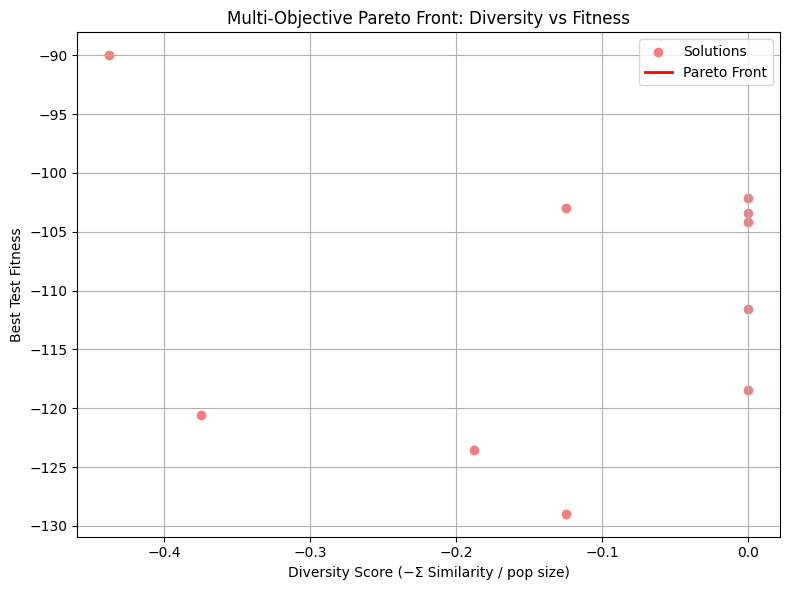

In [23]:
# Plotting the Pareto front

import matplotlib.pyplot as plt

# Multi-objective data averaged against 3 runs
pop_size = 16
multi_div = [0, 0, 0, 0, 0, -2, -2, -6, -7, -3] 
multi_div_normalized = [round(val / pop_size, 4) for val in multi_div]
multi_fitness = [-104.205, -111.564, -118.442, -103.382, -102.150,
                 -102.985, -128.965, -120.529, -89.998, -123.512]

# Extract Pareto front (maximizing both diversity and fitness)
def extract_pareto_front(div, fit):
    points = sorted(zip(div, fit), key=lambda x: x[0])  # sort by diversity
    pareto = []
    best_so_far = float('-inf')
    for d, f in points:
        if f > best_so_far:
            pareto.append((d, f))
            best_so_far = f
    return zip(*pareto)

# Extract Pareto points
pareto_div, pareto_fit = extract_pareto_front(multi_div_normalized, multi_fitness)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(multi_div_normalized, multi_fitness, color='lightcoral', label="Solutions")
plt.plot(pareto_div, pareto_fit, color='red', linewidth=2, label="Pareto Front")

plt.xlabel("Diversity Score (−Σ Similarity / pop size)")
plt.ylabel("Best Test Fitness")
plt.title("Multi-Objective Pareto Front: Diversity vs Fitness")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

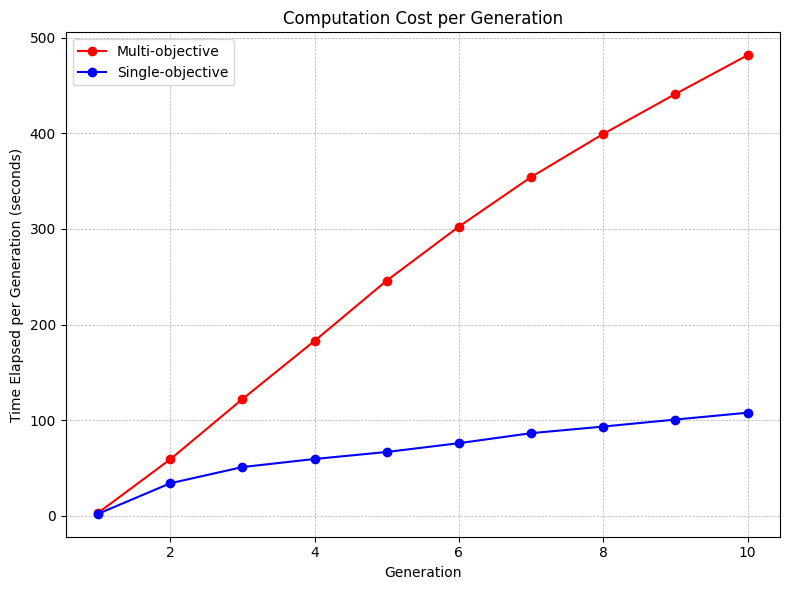

In [24]:
# Plotting the computation cost of multi-objective optimization

import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load data
csv_path = "improvement_results/multiobjective_improvement.csv"
df = pd.read_csv(csv_path)

# Extract time elapsed lists from row 2 (multi) and row 3 (single)
multi_time_raw = ast.literal_eval(df.loc[2, "time_elapsed"])
single_time_raw = ast.literal_eval(df.loc[3, "time_elapsed"])

# X-axis: generation numbers
generations = list(range(1, len(multi_time_raw) + 1))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(generations, multi_time_raw, marker='o', color='red', label='Multi-objective')
plt.plot(generations, single_time_raw, marker='o', color='blue', label='Single-objective')

plt.xlabel("Generation")
plt.ylabel("Time Elapsed per Generation (seconds)")
plt.title("Computation Cost per Generation")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Test 4: Diverse init


In [25]:
def diverse_init_exp(max_gens=30, pop_size = 16, has_wind=False, is_diverse=True):
    reward_type = "avg"
    fitness_function_version = make_fitness_function_pt(
        reduction=reward_type, has_wind=has_wind
    )
    print(f"\nRunning experiment diverse init case: {is_diverse}")
    (
        best_training,
        best_test,
        average_fitness,
        average_fitness_test,
        time_elapsed,
        num_evals,
    ) = main_experimentation_loop(
        fitness_function_version,
        internal_nodes,
        leaf_nodes,
        pop_size=pop_size,
        max_gens=max_gens,
        max_tree_size=31,
        is_diverse=is_diverse,
    )
    print(
        f"Best training fitness: {best_training}, Best test fitness: {best_test}, Average fitness: {average_fitness}, Average test fitness: {average_fitness_test}, Time elapsed: {time_elapsed}, Number of evaluations: {num_evals}"
    )
    write_results_to_csv_multiobjective(
        internal_nodes=internal_nodes,
        leaf_nodes=leaf_nodes,
        has_wind=has_wind,
        reward_type=reward_type,
        is_multiobjective=is_diverse,
        pop_size=pop_size,
        max_gens=max_gens,
        best_training=best_training,
        best_test=best_test,
        average_fitness=average_fitness,
        time_elapsed=time_elapsed,
        num_evals=num_evals,
        test_name= "diverse_improvement.csv"
    )


if perform_diverse_init_test:
    diverse_init_exp(max_gens=30, pop_size=64, has_wind=False, is_diverse=False)
    diverse_init_exp(max_gens=30, pop_size=64, has_wind=True, is_diverse= False)
    
    


Running experiment diverse init case: False
gen: 1, best of gen fitness: -103.055,	best of gen size: 25
gen: 2, best of gen fitness: -67.737,	best of gen size: 31
gen: 3, best of gen fitness: -83.377,	best of gen size: 31
gen: 4, best of gen fitness: -60.187,	best of gen size: 31
gen: 5, best of gen fitness: -77.556,	best of gen size: 31
gen: 6, best of gen fitness: -30.542,	best of gen size: 29
gen: 7, best of gen fitness: -34.983,	best of gen size: 27
gen: 8, best of gen fitness: -34.902,	best of gen size: 29
gen: 9, best of gen fitness: -49.300,	best of gen size: 29
gen: 10, best of gen fitness: -38.442,	best of gen size: 29
gen: 11, best of gen fitness: -50.090,	best of gen size: 31


KeyboardInterrupt: 

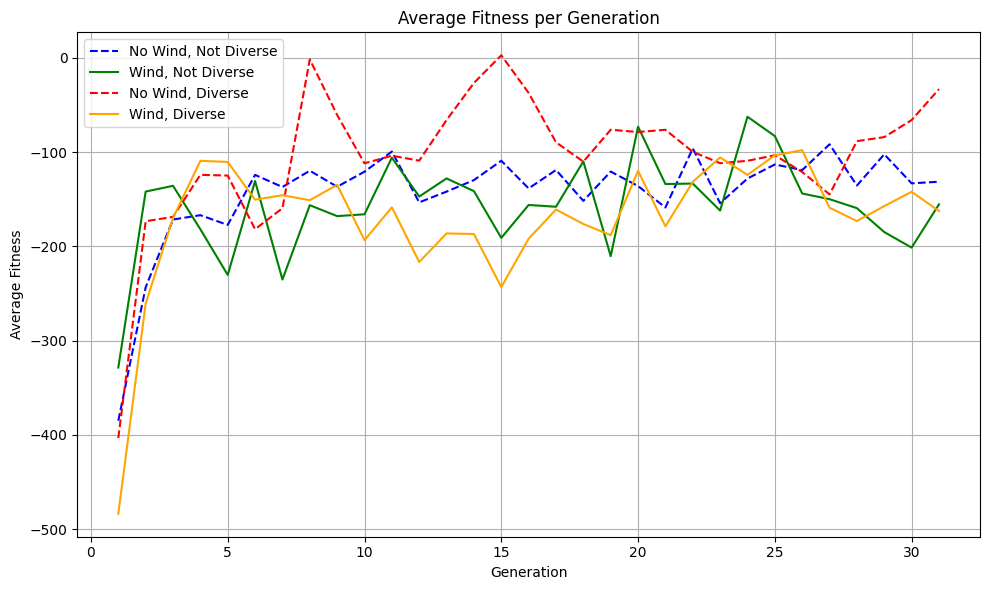

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load CSV (skip the comment line if present)
csv_path = "improvement_results/diverse_improvement_p16.csv"
df = pd.read_csv(csv_path, comment='/')

# Helper to parse the list of floats from the string
def parse_np_float_list(s):
    # Remove 'np.float64(' and ')'
    s = s.replace('np.float64(', '').replace(')', '')
    # Split by comma, convert to float
    return [float(x) for x in s.strip('[]').split(',')]

# Prepare plot
plt.figure(figsize=(10, 6))

# Color and style mapping
color_map = {(False, False): 'blue', (False, True): 'green', (True, False): 'red', (True, True): 'orange'}
label_map = {(False, False): 'No Wind, Not Diverse', (False, True): 'Wind, Not Diverse',
             (True, False): 'No Wind, Diverse', (True, True): 'Wind, Diverse'}

for _, row in df.iterrows():
    # Only plot unique (has_wind, is_diverse) combinations
    has_wind = row['has_wind'] == True or row['has_wind'] == 'True'
    is_diverse = row['is_diverse'] == True or row['is_diverse'] == 'True'
    avg_fitness = parse_np_float_list(row['average_fitness'])
    generations = list(range(1, len(avg_fitness) + 1))
    color = color_map[(has_wind, is_diverse)]
    label = label_map[(has_wind, is_diverse)]
    linestyle = '-' if is_diverse else '--'
    plt.plot(generations, avg_fitness, linestyle, color=color, label=label)

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('Average Fitness per Generation')
plt.grid(True)
plt.tight_layout()
plt.show()

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path="./", filename="evolved_lander.gif"):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer="imagemagick", fps=60)

In [ ]:
if perform_normal_evolution:
    frames = []
    fitness_function_pt(
        best, num_episodes=1, episode_duration=500, render=True, ignore_done=False
    )
    env.close()
    save_frames_as_gif(frames, filename="evolved_lander_RL.gif")

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
if perform_normal_evolution:
    batch_size = 128
    GAMMA = 0.99

    constants = best.get_subtrees_consts()

    if len(constants) > 0:
        optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

    for _ in range(500):

        if len(constants) > 0 and len(evo.memory) > batch_size:
            target_tree = copy.deepcopy(best)

            transitions = evo.memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool
            )

            non_final_next_states = torch.cat(
                [s for s in batch.next_state if s is not None]
            )
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            state_action_values = best.get_output_pt(state_batch).gather(
                1, action_batch
            )
            next_state_values = torch.zeros(batch_size, dtype=torch.float)
            with torch.no_grad():
                next_state_values[non_final_mask] = (
                    target_tree.get_output_pt(non_final_next_states).max(1)[0].float()
                )

            expected_state_action_values = (next_state_values * GAMMA) + reward_batch

            criterion = nn.SmoothL1Loss()
            loss = criterion(
                state_action_values, expected_state_action_values.unsqueeze(1)
            )

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(constants, 100)
            optimizer.step()

    print(best.get_readable_repr())
    print(get_test_score(best))

<img src="evolved_lander_RL.gif" width="750">

## Hyperparameter Tuning Plots

Below are some plotting cells used to gauge the right hyperparameters for the GP algorithm. The plots are generated from the results of the hyperparameter tuning experiments.

In [ ]:
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")

parameters = ["crossover_rate", "mutation_rate", "coeff_opt_rate", "tournament_size"]

# little wonky conversion to take the last float because the array looks like "[np.float64(-134359.23), np.float64(-213.35), ...
df["average_fitness"] = df["average_fitness"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, param in enumerate(parameters):
    ax = axes[i]
    df.boxplot(column="average_fitness", by=param, ax=ax)
    # ax.scatter(df[param], df['average_fitness'], alpha=0.5)
    ax.set_xlabel(param)
    ax.set_ylabel("average_fitness")
    ax.set_title(f"{param} vs average_fitness")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'hyperparameter_tuning_results/resultscombined'

In [ ]:
import pandas as pd
import plotly.express as px

# Load and clean data
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")
df["best_training"] = df["best_training"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)
df = df[df["tournament_size"] == 8]
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="crossover_rate",
    y="mutation_rate",
    z="coeff_opt_rate",
    color="best_training",
    color_continuous_scale="Viridis",
    opacity=0.8,
    title="3D Scatter Plot of Hyperparameters vs Average Fitness",
    labels={
        "crossover_rate": "Crossover Rate",
        "mutation_rate": "Mutation Rate",
        "coeff_opt_rate": "Coeff Opt Rate",
        "best_training": "Best Fitness",
    },
)

# Set renderer (if needed)
import plotly.io as pio

pio.renderers.default = (
    "browser"  # Try 'iframe_connected' or 'browser' if this doesn't show
)

fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Heatmap with One Facet: Coeff Opt Rate

# Load and preprocess data
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")
df["best_training"] = df["best_training"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)
df = df[df["tournament_size"] == 8]

# Round to avoid floating point noise in axes
df["crossover_rate"] = df["crossover_rate"].round(3)
df["mutation_rate"] = df["mutation_rate"].round(3)
df["coeff_opt_rate"] = df["coeff_opt_rate"].round(3)

# Create faceted heatmaps
fig = px.density_heatmap(
    df,
    x="crossover_rate",
    y="mutation_rate",
    z="best_training",
    facet_col="coeff_opt_rate",
    color_continuous_scale="Viridis",
    histfunc="avg",
    title="Hyperparameter Heatmaps: Fitness vs Crossover & Mutation (Faceted by Coeff Opt Rate)",
    labels={
        "crossover_rate": "Crossover Rate",
        "mutation_rate": "Mutation Rate",
        "best_training": "Best Fitness",
        "coeff_opt_rate": "Coeff Opt Rate",
    },
)

fig.update_layout(margin=dict(l=20, r=20, t=50, b=20))
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Heatmap with Two Facets: Coeff Opt Rate and Tournament Size
# This heatmap uses best_fitness metric for selection
# and averages this metric across generations

# Load and preprocess data
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")

# Extract float value from 'best_training' column
df["best_training"] = df["best_training"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)

# Round to avoid floating point noise in axes
df["crossover_rate"] = df["crossover_rate"].round(3)
df["mutation_rate"] = df["mutation_rate"].round(3)
df["coeff_opt_rate"] = df["coeff_opt_rate"].round(3)
df["tournament_size"] = df["tournament_size"]

# Remove configuration where crossover_rate == 1.0
df = df[df["crossover_rate"] != 1.0]

# Create faceted heatmaps with mutation_rate as row facet and crossover_rate as column facet
fig = px.density_heatmap(
    df,
    x="tournament_size",
    y="coeff_opt_rate",
    z="best_training",
    facet_row="mutation_rate",
    facet_col="crossover_rate",
    histfunc="avg",
    color_continuous_scale="Viridis",
    title="Fitness Heatmaps: Tournament Size vs Coeff Opt Rate (Faceted by Mutation & Crossover Rate)",
    labels={
        "tournament_size": "Tournament Size",
        "coeff_opt_rate": "Coeff Opt Rate",
        "best_training": "Best Fitness",
        "mutation_rate": "Mutation Rate",
        "crossover_rate": "Crossover Rate",
    },
)

# Improve layout
fig.update_layout(margin=dict(l=20, r=20, t=60, b=20), height=800, width=1000)

# Reduce font size of facet labels to prevent overlap
for annotation in fig.layout.annotations:
    annotation.font.size = 10

fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Heatmap with Two Facets: Coeff Opt Rate and Tournament Size
# This heatmap uses avg_fitness metric for selection

# Load and preprocess data
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")

# Extract float value from 'average_fitness' column
df["average_fitness"] = df["average_fitness"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)

# Round to avoid floating point noise in axes
df["crossover_rate"] = df["crossover_rate"].round(3)
df["mutation_rate"] = df["mutation_rate"].round(3)
df["coeff_opt_rate"] = df["coeff_opt_rate"].round(3)
df["tournament_size"] = df["tournament_size"]

# Create faceted heatmaps with tournament_size as row facet and coeff_opt_rate as column facet
fig = px.density_heatmap(
    df,
    x="crossover_rate",
    y="mutation_rate",
    z="average_fitness",
    facet_row="tournament_size",  # ← Add tournament_size as row facet
    facet_col="coeff_opt_rate",  # ← Coeff mutation rate as column facet
    histfunc="avg",
    color_continuous_scale="Viridis",
    title="Fitness Heatmaps: Crossover vs Mutation (Faceted by Coeff Opt Rate and Tournament Size)",
    labels={
        "crossover_rate": "Crossover Rate",
        "mutation_rate": "Mutation Rate",
        "average_fitness": "Average Fitness",
        "coeff_opt_rate": "Coeff Opt Rate",
        "tournament_size": "Tournament Size",
    },
)

# Improve layout
fig.update_layout(margin=dict(l=20, r=20, t=60, b=20), height=800, width=1000)

for annotation in fig.layout.annotations:
    annotation.font.size = 10

fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load and clean data
df = pd.read_csv("hyperparameter_tuning_results/resultscombined")
df["best_training"] = df["best_training"].apply(
    lambda x: float(x.split(", ")[-1].split("(")[-1][:-3])
)

# Filter by tournament_size and a fixed coeff_opt_rate value (adjust if needed)
df = df[df["tournament_size"] == 8]
df["coeff_opt_rate"] = df["coeff_opt_rate"].round(3)
target_coeff = df["coeff_opt_rate"].unique()[0]  # Use first value or set manually
df = df[df["coeff_opt_rate"] == target_coeff]

# Round to reduce float precision issues
df["crossover_rate"] = df["crossover_rate"].round(3)
df["mutation_rate"] = df["mutation_rate"].round(3)

# Pivot data to create Z-matrix
pivot_df = df.pivot_table(
    values="best_training",
    index="mutation_rate",
    columns="crossover_rate",
    aggfunc="mean",  # or 'min' depending on your definition of "best"
)

# Extract axes
x = pivot_df.columns.values  # crossover_rate
y = pivot_df.index.values  # mutation_rate
z = pivot_df.values  # best_training

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale="Viridis")])
fig.update_layout(
    title="Average Fitness vs Hyperparameters",
    scene=dict(
        xaxis_title="Crossover Rate",
        yaxis_title="Mutation Rate",
        zaxis_title="Average Fitness",
    ),
)
fig.show()